# MNASNet 0.75 model training Notebook

 ## Data Preprocessing

In [1]:
"""
Import Libraries and Set Random Seed
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, sampler, random_split
import numpy as np
from collections import namedtuple
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
import os
import pandas as pd
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torch.optim.lr_scheduler import LambdaLR
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import random
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt

#define pytorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#torch.cuda.set_per_process_memory_fraction(0.5, 0)


SEED = 119
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
"""
Use pipeline detailed in data_prep_training.py to import the dataloaders for model training:
"""
from data_prep_training import get_dataloaders

path = '../../data/preprocessed_renamed'

train_loader, val_loader, test_loader = get_dataloaders(path, batch_size=100, img_size=(100, 100), train_ratio=0.8, val_ratio=0.05)


In [3]:
torch.save(train_loader, './output/train_loader.pth')

torch.save(val_loader, './output/val_loader.pth')

torch.save(test_loader, './output/test_loader.pth')


 ## Defining a Convolutional Neural Network

In [4]:
"""
Load pretrained AlexNet model that will be fine-tuned with the MRI dataset.
MRI dataset has 5 classes of Lumbar Spine Degenerative Conditions.
"""

#init a pretrained AlexNet model from Pytorch, edit the last classifier layer to output 5 classes
model =  models.mnasnet1_3(weights=models.MNASNet1_3_Weights.IMAGENET1K_V1)
num_classes = 5
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(model.classifier[1].in_features, num_classes)
)
model.to(device)

#model.features[0] = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2) #this is to allow for our images to fit (100x100)
#model.classifier[6] = nn.Linear(model.classifier[6].in_features, 5) #change to 5 outputs for the 5 classes
#model = model.to(device)


MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(24, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(72, 

In [5]:
def eval_or_train(model, dataloader, optimizer, criterion, device, mode = 'eval'):
    if mode == 'train':
        #init training mode
        model.train()
        #init running loss, correct preds, and total correct preds for each epoch
        epoch_total_loss = 0.0
        epoch_correct_preds = 0
        epoch_total_preds = 0
        all_labels = []
        all_preds = []

        for _, (data,target) in enumerate(dataloader):
            
            #init data and target into cuda
            data = data.to(device)
            target = target.to(device)

            
            optimizer.zero_grad()
            #predict using input data
            curr_pred = model(data)
            #calculate loss of prediction with true label
            curr_loss = criterion(curr_pred, target)

            #backprop
            curr_loss.backward()
            #gradient descent step
            optimizer.step()

            epoch_total_loss += curr_loss.item() * data.size(0)
            _, predicted = torch.max(curr_pred, 1)

            epoch_correct_preds += (predicted == target).sum().item()
            epoch_total_preds += target.size(0)

            all_labels.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
        

        train_avg_loss = epoch_total_loss / len(train_loader.dataset)
        train_acc = accuracy_score(all_labels, all_preds)

        return train_avg_loss, train_acc
    
    elif mode == 'eval':
        #init eval mode
        model.eval()
        #init running loss, correct preds, and total correct preds for each epoch
        epoch_total_loss = 0.0
        epoch_correct_preds = 0
        epoch_total_preds = 0
        all_labels = []
        all_preds = []


        for _, (data,target) in enumerate(dataloader):
            
            #init data and target into cuda
            data = data.to(device)
            target = target.to(device)

            #predict using input data
            curr_pred = model(data)
            #calculate loss of prediction with true label
            curr_loss = criterion(curr_pred, target)

            #add to running loss and get prediction
            epoch_total_loss += curr_loss.item() * data.size(0)
            _, predicted = torch.max(curr_pred, 1)

            #get the number of correct preds and total preds
            epoch_correct_preds += (predicted == target).sum().item()
            epoch_total_preds += target.size(0)

            all_labels.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
        
        eval_avg_loss = epoch_total_loss / len(train_loader.dataset)
        eval_acc = accuracy_score(all_labels, all_preds)
        

        return eval_avg_loss, eval_acc


In [6]:
"""
Init parameters, optimizer, loss function, lr-scheduler, 
"""

# define model parameters
NUM_EPOCHS = 40
NUM_CLASSES = 5

#define optimizer and loss functions
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

#learning rate scheduler
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.1**(epoch // 30))



In [7]:
class EarlyStopping():
    def __init__(self, patience = 2, verbose = False, delta = 0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_loss = None
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            if self.best_loss is not None:
                print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
            else:
                print(f'Saving model with validation loss: {val_loss:.6f}')

        self.best_loss = val_loss
        torch.save(model.state_dict(), 'best_model_MNASNet-1-3.pt')

In [8]:
"""
Run epochs
"""
#init loss lists
train_loss_list = []
val_loss_list = []
test_loss_list = []
train_acc_list = []
val_acc_list = []
test_acc_list = []

#for checkpointing later
best_val_accuracy = 0  
best_test_accuracy = 0
output_folder = "./output/"
early_stopping = EarlyStopping(patience = 5, verbose = False)


for e in range(1, NUM_EPOCHS+1):

    train_loss, train_acc = eval_or_train(model, train_loader, optimizer, criterion, device, mode = 'train')
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    val_loss, val_acc = eval_or_train(model, val_loader, optimizer, criterion, device, mode = 'eval')
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    test_loss, test_acc = eval_or_train(model, test_loader, optimizer, criterion, device, mode = 'eval')
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    scheduler.step()

    # Checkpointing
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        #torch.save(model.state_dict(), os.path.join(output_folder, f'MNASNet_project_best_Aaron.pth'))
    if test_acc > best_test_accuracy:
        best_test_accuracy = test_acc
        torch.save(model.state_dict(), os.path.join(output_folder, f'MNASNet_project_best_Aaron.pth'))

    print("Epoch number:", e, "/", NUM_EPOCHS)
    print("      Train acc -- ", train_acc, "; Train loss -- ", train_loss)
    print("      Validation acc -- ", val_acc, "; Validation loss -- ", val_loss)
    print("      Test acc -- ", test_acc, "; Test loss -- ", test_loss)

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
      print("Early stopping")
      break

Epoch number: 1 / 40
      Train acc --  0.9493320457106068 ; Train loss --  0.1660387180310145
      Validation acc --  0.9438433797011849 ; Validation loss --  0.009977679077638399
      Test acc --  0.9267078613113628 ; Test loss --  0.03773747878327532
Epoch number: 2 / 40
      Train acc --  0.9989055206824401 ; Train loss --  0.0046235202652877855
      Validation acc --  0.9747552807831015 ; Validation loss --  0.005631431680830439
      Test acc --  0.9620665980089255 ; Test loss --  0.024046465030676614
Epoch number: 3 / 40
      Train acc --  0.999388379204893 ; Train loss --  0.002982499244861488
      Validation acc --  0.988665636269964 ; Validation loss --  0.0021461881043618185
      Test acc --  0.9831788534157226 ; Test loss --  0.010408269315862088
Epoch number: 4 / 40
      Train acc --  0.9995815226138741 ; Train loss --  0.0014979907872973983
      Validation acc --  0.9927872230808862 ; Validation loss --  0.0014100982829986558
      Test acc --  0.987469962238242

In [9]:
print(f"Best val accuracy: {best_val_accuracy}")
print(f"Best test accuracy: {best_test_accuracy}")


Best val accuracy: 1.0
Best test accuracy: 0.9975969790593889


In [12]:
num_layers = sum(1 for name, layer in model.named_modules() if isinstance(layer, torch.nn.Module))
print(num_layers)

182


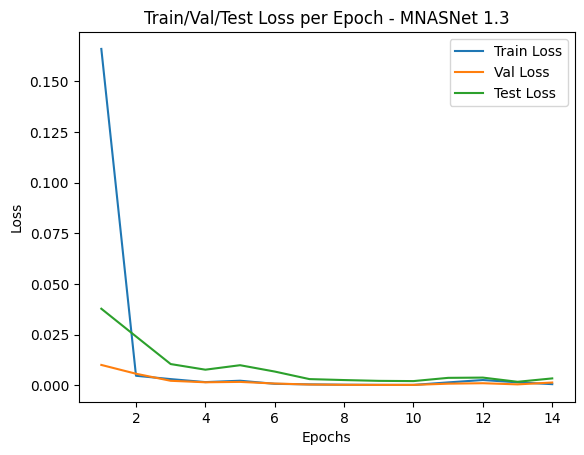

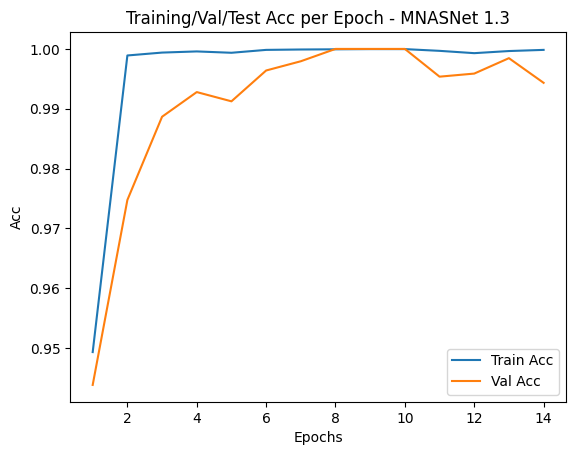

In [10]:
"""
Display losses and accuracy:
"""

fig = plt.figure()
plt.plot(np.linspace(1, len(train_loss_list), len(train_loss_list)), train_loss_list, label = 'Train Loss')
plt.plot(np.linspace(1, len(val_loss_list), len(val_loss_list)), val_loss_list, label = 'Val Loss')
plt.plot(np.linspace(1, len(test_loss_list), len(test_loss_list)), test_loss_list, label = 'Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val/Test Loss per Epoch - MNASNet 1.3')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(np.linspace(1, len(train_acc_list), len(train_acc_list)), train_acc_list, label = 'Train Acc')
plt.plot(np.linspace(1, len(val_acc_list), len(val_acc_list)), val_acc_list, label = 'Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title('Training/Val/Test Acc per Epoch - MNASNet 1.3')
plt.legend()
plt.show()

In [11]:
losses = pd.DataFrame()
losses['train_losses'] = train_loss_list
losses['test_losses'] = test_loss_list
losses.to_csv("losses_list_MNASNet_1-3.csv")